In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from datetime import datetime

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Duration and CDF Plotting") \
    .getOrCreate()

# List of CSV file paths
directory_path = "../data"

# Read all CSV files in the directory into a DataFrame
dataframes  = spark.read.csv(directory_path, header=True, inferSchema=True)

# Filter for rideable_type = classic_bike
dataframes = dataframes.filter(col("rideable_type") == "classic_bike")

# Preprocess DataFrame to filter out data outside the specified date range
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 2, 28)

filtered_df = dataframes.filter((col("started_at") >= start_date) & (col("ended_at") <= end_date))

# Calculate the duration in minutes
duration_df = filtered_df.withColumn(
    "duration",
    expr("(unix_timestamp(ended_at) - unix_timestamp(started_at)) / 60")
)

# Prepare the data for plotting
duration_values = duration_df.select("duration").rdd.flatMap(lambda x: x).collect()
duration_values = sorted(duration_values)

# Calculate the Euclidean distance in kilometers
distance_df = duration_df.withColumn(
    "distance",
    expr("SQRT(POWER(end_lat - start_lat, 2) + POWER(end_lng - start_lng, 2)) * 111.32")
)
# Filter out rows where the distance is not null
distance_df = distance_df.filter(col("distance").isNotNull())

# Prepare the data for plotting
distance_values = distance_df.select("distance").rdd.flatMap(lambda x: x).collect()
distance_values = sorted(distance_values)

# Stop the SparkSession
spark.stop()


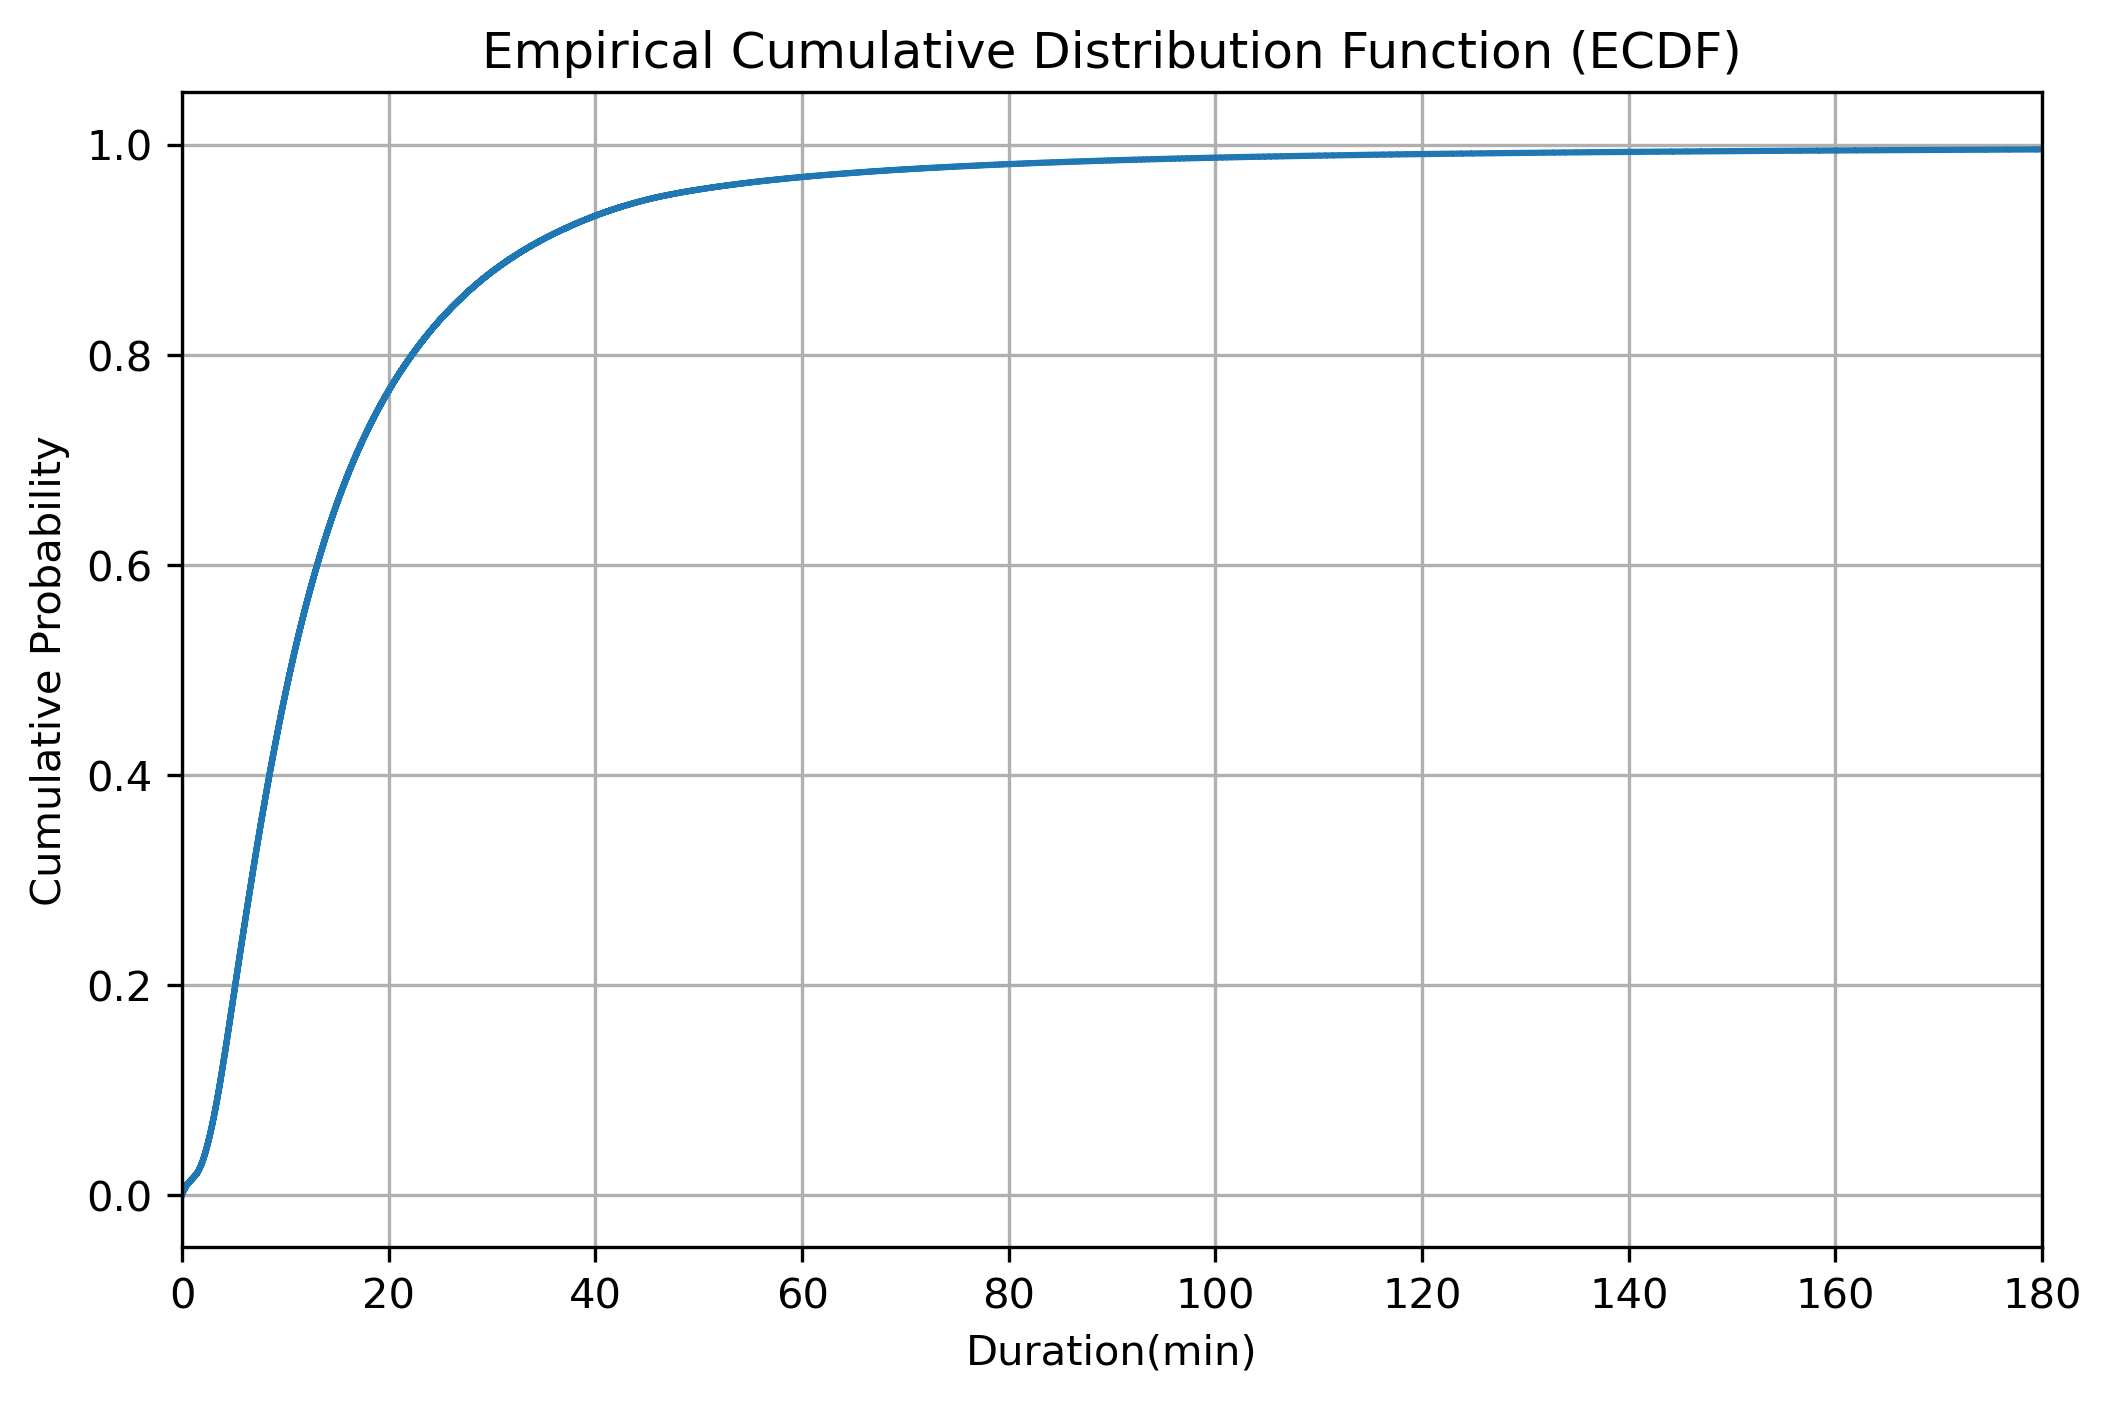

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Calculate ECDF
ecdf_func = ECDF(duration_values)

# Generate data for plotting
x = np.sort(duration_values)
y = ecdf_func(x)

# Plot ECDF
plt.figure(figsize=(8,5), dpi=300)
plt.step(x, y, linestyle='-')
plt.xlabel('Duration(min)')
plt.xlim((0,180))
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function (ECDF)')
plt.grid(True)
plt.show()

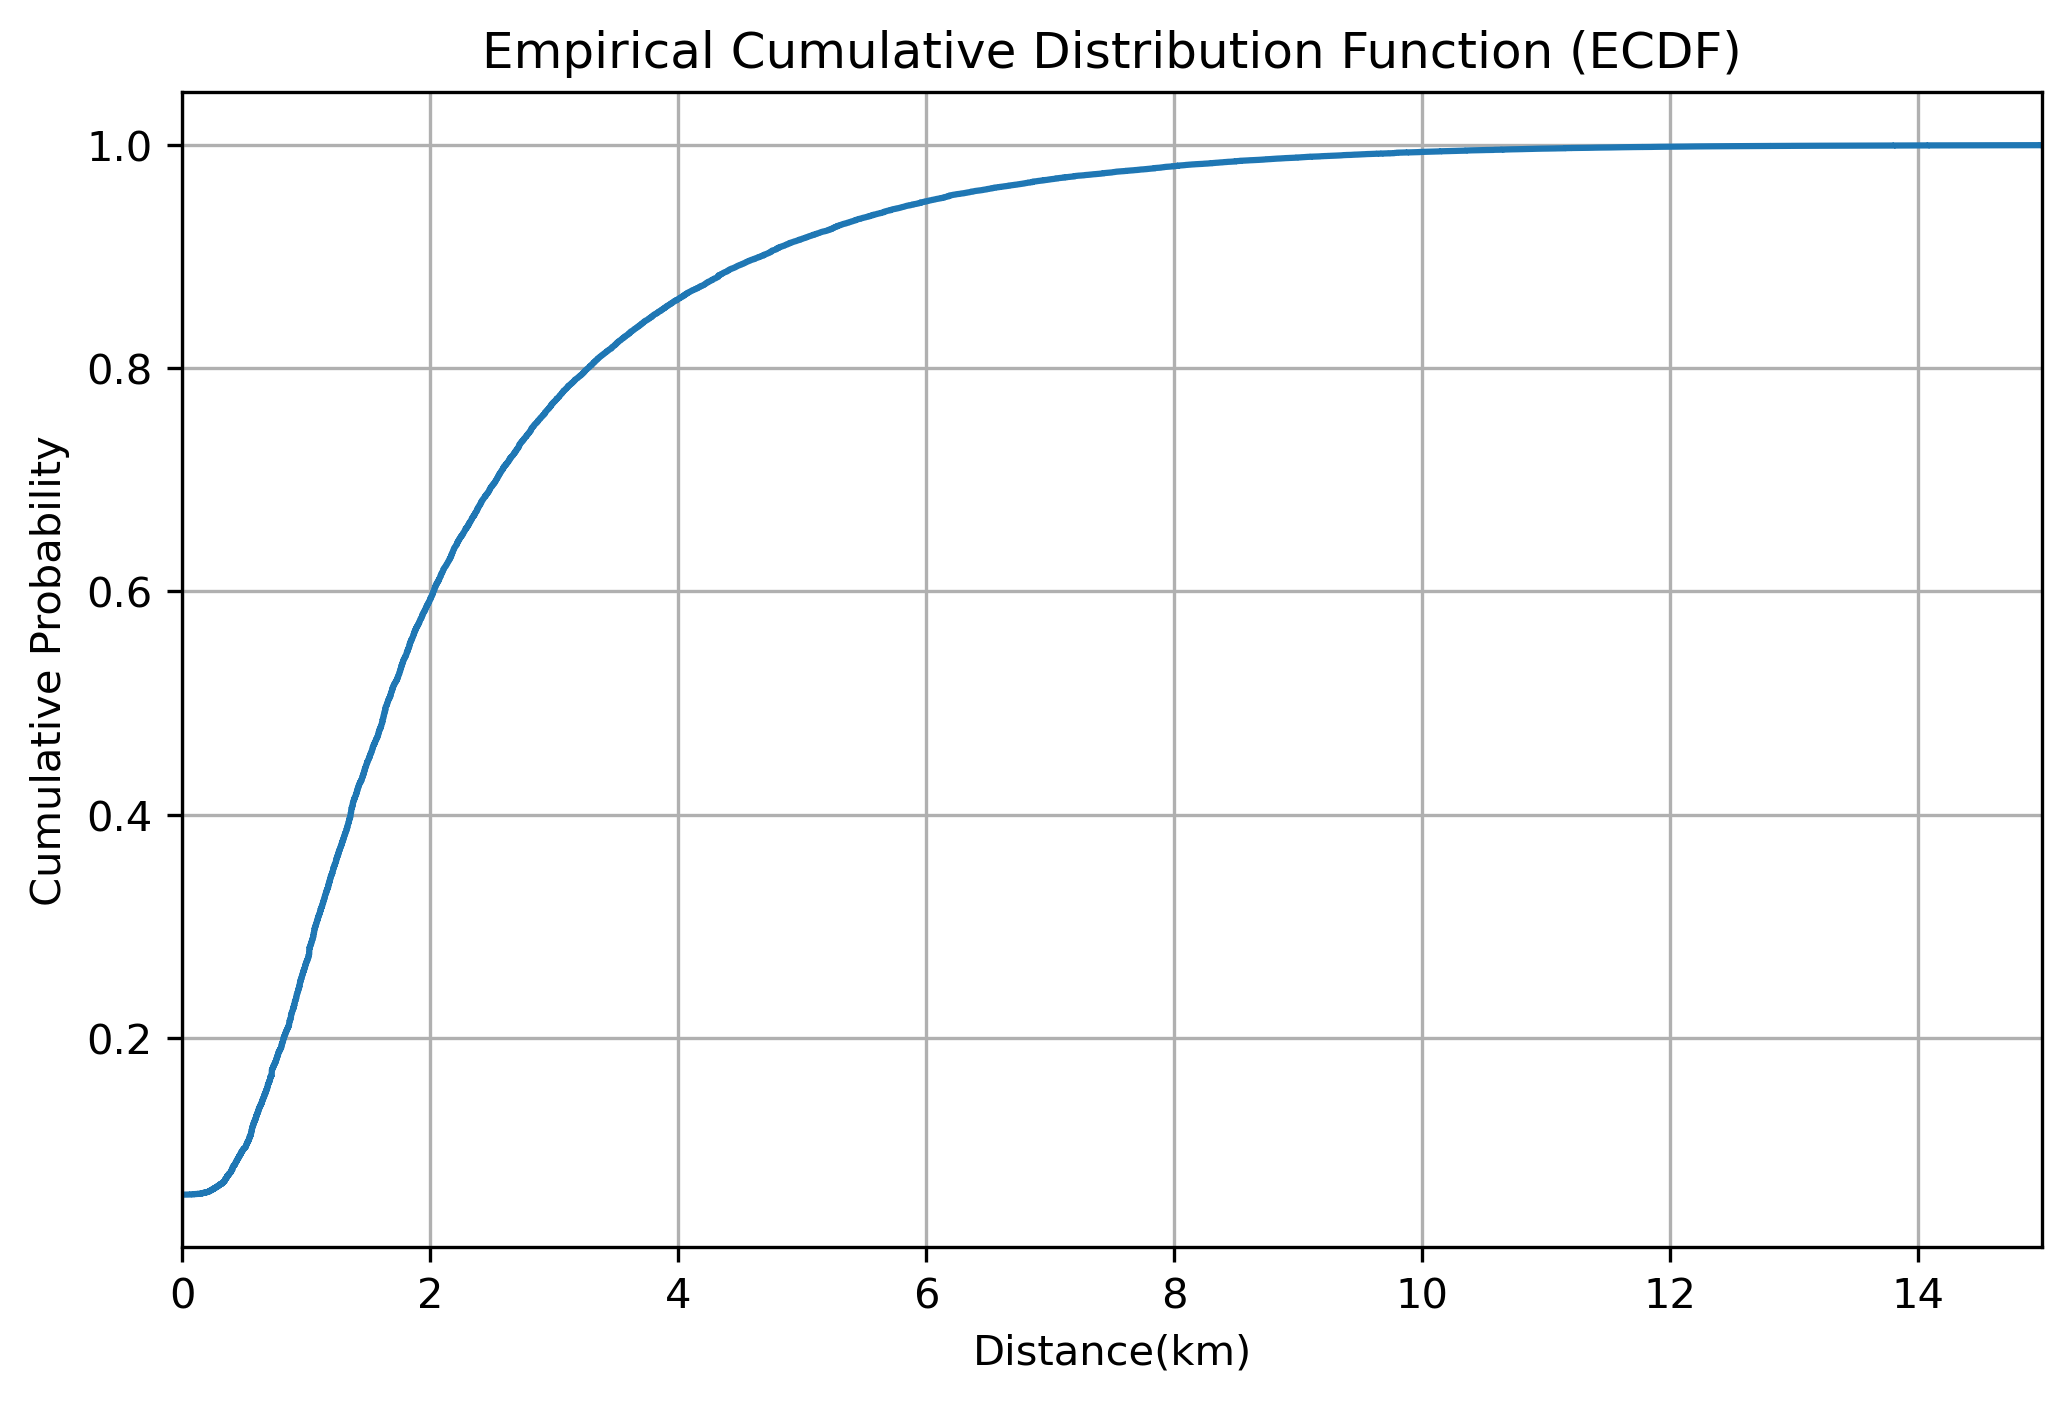

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Calculate ECDF
ecdf_func = ECDF(distance_values)

# Generate data for plotting
x = np.sort(distance_values)
y = ecdf_func(x)

# Plot ECDF
plt.figure(figsize=(8,5), dpi=300)
plt.step(x, y, linestyle='-')
plt.xlabel('Distance(km)')
plt.xlim((0,15))
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function (ECDF)')
plt.grid(True)
plt.show()